In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import tensorflow as tf
from scipy.stats import spearmanr

import helper, residualbind
sys.path.append('..')
from deepomics import neuralnetwork as nn
from deepomics import fit

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# different deep learning models to try out
model = 'residualbind'
normalize_method = 'log_norm'   # 'log_norm' or 'clip_norm'  
ss_type = 'seq'                  # 'seq', 'pu', or 'struct'

data_path = '../data/RNAcompete_2013/rnacompete2013.h5'
results_path = helper.make_directory('../results', 'RNAcompete_2013')
save_path = helper.make_directory(results_path, normalize_method+'_'+ss_type)

In [3]:
# get list of rnacompete experiments
experiments = helper.get_experiments_hdf5(data_path)

In [4]:
msi_motif = [[0.660616633976529,	0.0820608020629914,	0.0820608020629914,	0.175261761133027],
[0.0322686340617958,	0.0322686340617958,	0.903194098020484,	0.0322686340617958],
[0.00774780942310276,	0.00774780942310276,	0.00774780942310276,	0.976756573989969],
[0.976756573989969,	0.00774780942310276,	0.00774780942310276,	0.00774780942310276],
[0.00774780942310276,	0.00774780942310276,	0.976756573989969,	0.00774780942310276],
[0.0956116884451417,	0.00774780942310276,	0.400652981118079,	0.495987523272951],
[0.262539452666875,	0.0793525388664719,	0.180468924423524,	0.477639081584509]]

motif = np.array(msi_motif)
rbp_index = list(experiments).index('RNCMPT00040')
experiment = experiments[rbp_index]

In [5]:
# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)

X = np.squeeze(test['inputs'])
Y = np.squeeze(test['targets'])

In [8]:
N, L, A = X.shape
M = len(motif)
pwm_pos = []
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    pwm_pos.append([np.array(score)])
pwm_pos = np.vstack(pwm_pos)

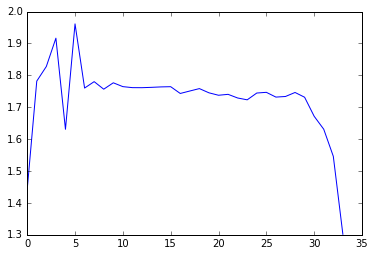

In [11]:
plt.plot(np.mean(pwm_pos, axis=0))

In [108]:
N, L, A = X.shape
M = len(motif)
pwm_score = np.zeros(N)
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    score = np.array(score)
    pwm_score[n] = np.mean(score)

In [109]:

# get shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model
model_layers, optimization = residualbind.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainer
file_path = os.path.join(save_path, experiment)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)


# start session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # load best model
    nntrainer.set_best_parameters(sess)
    predictions = nntrainer.get_activations(sess, test, layer='output')


loading model from:  ../results/RNAcompete_2013/log_norm_seq/RNCMPT00040_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/RNAcompete_2013/log_norm_seq/RNCMPT00040_best.ckpt


(-4, 12)

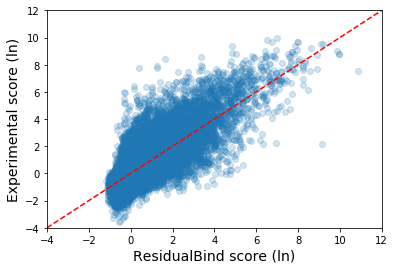

In [132]:
MIN=-4
MAX=12
plt.scatter(predictions, Y, alpha=0.2)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
plt.xlabel('ResidualBind score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


(-4, 12)

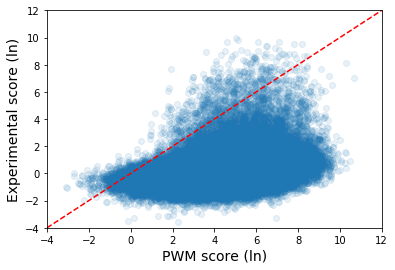

In [131]:
num_fit =70000
max_index = np.argsort(pwm_score)[::-1]
m, c = np.linalg.lstsq(np.vstack([pwm_score[max_index[:num_fit]], np.ones(num_fit)]).T, Y[max_index[:num_fit]])[0]

fig = plt.figure()
plt.scatter(pwm_score*10-13, Y, alpha=0.1)
plt.xlabel('PWM score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
#plt.plot([-5,15],[-5,15],'--r')
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])

In [133]:
print(spearmanr(pwm_score, Y))
print(np.corrcoef(pwm_score,Y))

SpearmanrResult(correlation=0.31212950162388725, pvalue=0.0)
[[1.         0.30651771]
 [0.30651771 1.        ]]


In [134]:
print(spearmanr(predictions[:,0], Y))
print(np.corrcoef(predictions[:,0],Y))

SpearmanrResult(correlation=0.7101368357762876, pvalue=0.0)
[[1.         0.79933592]
 [0.79933592 1.        ]]


In [5]:
rbfox_motif = [[0.312096560381765,	0.0517475986102623,	0.0517475986102623,	0.584408242979162],
[0.004218445786123,	0.004218445786123,	0.98734466264412,	0.004218445786123],
[0.004218445786123,	0.98734466264412,	0.004218445786123,	0.004218445786123],
[0.98734466264412,	0.004218445786123,	0.004218445786123,	0.004218445786123],
[0.004218445786123,	0.004218445786123,	0.004218445786123,	0.98734466264412],
[0.004218445786123,	0.004218445786123,	0.98734466264412,	0.004218445786123],
[0.313687816216559,	0.481444869244603,	0.102433657159761,	0.102433657159761]]

motif = np.array(rbfox_motif)
rbp_index = list(experiments).index('RNCMPT00168')
experiment = experiments[rbp_index]

In [6]:
###### 
# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)

X = np.squeeze(test['inputs'])
Y = np.squeeze(test['targets'])

In [7]:
N, L, A = X.shape
M = len(motif)
pwm_pos = []
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    pwm_pos.append([np.array(score)])
pwm_pos = np.vstack(pwm_pos)

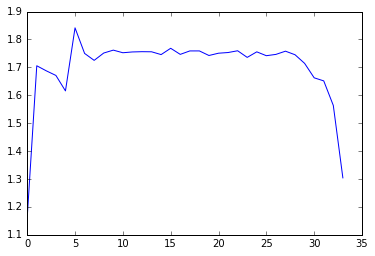

In [36]:
w = Y - np.min(Y)
plt.plot(np.sum((pwm_pos.T*w).T/np.sum(w), axis=0))

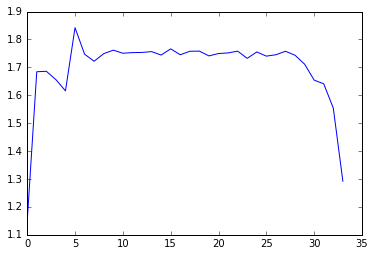

In [26]:
plt.plot(np.mean(pwm_pos, axis=0))

In [41]:
np.corrcoef(np.mean(pwm_pos, axis=1), Y)

array([[1.        , 0.19722921],
       [0.19722921, 1.        ]])

In [13]:
pwm_score

array([3.59625526, 3.65731278, 3.50366335, ..., 4.03632399, 3.65731278,
       3.50366335])

In [37]:
N, L, A = X.shape
M = len(motif)
pwm_score = np.zeros(N)
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    score = np.array(score)
    pwm_score[n] = np.max(score)

In [9]:

# get shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model
model_layers, optimization = residualbind.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainer
file_path = os.path.join(save_path, experiment)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)


# start session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # load best model
    nntrainer.set_best_parameters(sess)
    predictions = nntrainer.get_activations(sess, test, layer='output')


loading model from:  ../results/RNAcompete_2013/log_norm_seq/RNCMPT00168_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/RNAcompete_2013/log_norm_seq/RNCMPT00168_best.ckpt


(-5, 13)

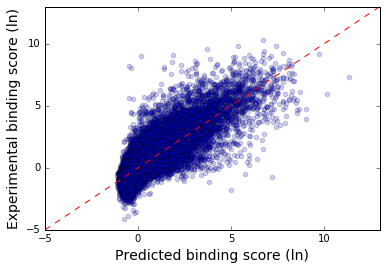

In [45]:
MIN=-5
MAX=13
plt.scatter(predictions, Y, alpha=0.2)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
plt.xlabel('Predicted binding score (ln)', fontsize=14)
plt.ylabel('Experimental binding score (ln)', fontsize=14)
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])

In [52]:
Y[max_index[:num_fit]]

array([-0.1499503 ,  0.7165986 ,  5.30885   , ...,  0.22294289,
       -0.52589816, -0.5482321 ], dtype=float32)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


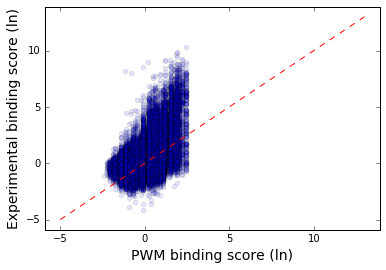

In [57]:
num_fit =70000
max_index = np.argsort(pwm_score)[::-1]
m, c = np.linalg.lstsq(np.vstack([pwm_score[max_index[:num_fit]], np.ones(num_fit)]).T, Y[max_index[:num_fit]])[0]

fig = plt.figure()
plt.scatter(pwm_score*m+c, Y, alpha=0.1)
plt.xlabel('PWM binding score (ln)', fontsize=14)
plt.ylabel('Experimental binding score (ln)', fontsize=14)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
#plt.plot([-5,15],[-5,15],'--r')
plt.axis('tight');
#plt.xlim([MIN,MAX])
#plt.ylim([MIN,MAX])



In [36]:
print(spearmanr(pwm_score, Y))
print(np.corrcoef(pwm_score,Y))

SpearmanrResult(correlation=0.24546188801407412, pvalue=0.0)
[[1.         0.19722921]
 [0.19722921 1.        ]]


In [26]:
print(spearmanr(predictions[:,0], Y))
print(np.corrcoef(predictions[:,0],Y))

SpearmanrResult(correlation=0.6564799232426481, pvalue=0.0)
[[1.         0.80954811]
 [0.80954811 1.        ]]


In [4]:
cpeb4 = [[0.169792511215775,	0.45246912127402,	0.164509463052899,	0.213228903790404],
[0.0969297458225215,	0.0919880574446695,	0.00658218974642937,	0.804500007214712],
[0.00658218974642937,	0.00658218974642937,	0.00658218974642937,	0.980253430989041],
[0.00658218974642937,	0.00658218974642937,	0.00658218974642937,	0.980253430989041],
[0.00658218974642937,	0.00658218974642937,	0.00658218974642937,	0.980253430989041],
[0.00658218974642937,	0.00658218974642937,	0.0905657264724462,	0.896269894263026],
[0.0305356185277595,	0.0305356185277595,	0.0305356185277595,	0.908393145775856]]

motif = np.array(cpeb4)
rbp_index = list(experiments).index('RNCMPT00158')
experiment = experiments[rbp_index]

In [149]:


# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)

X = np.squeeze(test['inputs'])
Y = np.squeeze(test['targets'])

In [150]:
N, L, A = X.shape
M = len(motif)
pwm_score = np.zeros(N)
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    score = np.array(score)
    pwm_score[n] = np.mean(score)

In [151]:

# get shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model
model_layers, optimization = residualbind.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainer
file_path = os.path.join(save_path, experiment)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)


# start session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # load best model
    nntrainer.set_best_parameters(sess)
    predictions = nntrainer.get_activations(sess, test, layer='output')


loading model from:  ../results/RNAcompete_2013/log_norm_seq/RNCMPT00158_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/RNAcompete_2013/log_norm_seq/RNCMPT00158_best.ckpt


(-5, 13)

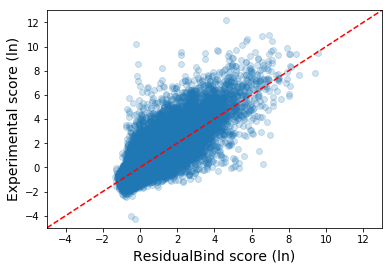

In [152]:
MIN=-5
MAX=13
plt.scatter(predictions, Y, alpha=0.2)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
plt.xlabel('ResidualBind score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


(-5, 13)

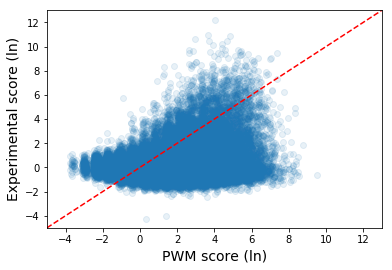

In [160]:
num_fit =70000
max_index = np.argsort(pwm_score)[::-1]
m, c = np.linalg.lstsq(np.vstack([pwm_score[max_index[:num_fit]], np.ones(num_fit)]).T, Y[max_index[:num_fit]])[0]

fig = plt.figure()
plt.scatter(pwm_score*4-5, Y, alpha=0.1)
plt.xlabel('PWM score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
#plt.plot([-5,15],[-5,15],'--r')
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])



In [161]:
print(spearmanr(pwm_score, Y))
print(np.corrcoef(pwm_score,Y))

SpearmanrResult(correlation=0.06852563494320868, pvalue=3.766114943176538e-125)
[[1.         0.20523431]
 [0.20523431 1.        ]]


In [162]:
print(spearmanr(predictions[:,0], Y))
print(np.corrcoef(predictions[:,0],Y))

SpearmanrResult(correlation=0.77527851909382, pvalue=0.0)
[[1.         0.83476836]
 [0.83476836 1.        ]]


In [163]:
rbm42 = [[0.762509870175323,	0.0791633768215905,	0.0791633768215905,	0.0791633768215905],
[0.974051961825069,	0.00864934515937539,	0.00864934515937539,	0.00864934515937539],
[0.00864934515937539,	0.974051961825069,	0.00864934515937539,	0.00864934515937539],
[0.00864934515937539,	0.00864934515937539,	0.00864934515937539,	0.974051961825069],
[0.974051961825069,	0.00864934515937539,	0.00864934515937539,	0.00864934515937539],
[0.521991671568225,	0.317983267747242,	0.0325968476589352,	0.127428216292518],
[0.104219040959224,	0.104219040959224,	0.687342879365605,	0.104219040959224]]

motif = np.array(rbm42)
rbp_index = list(experiments).index('RNCMPT00151')
experiment = experiments[rbp_index]

In [164]:


# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)

X = np.squeeze(test['inputs'])
Y = np.squeeze(test['targets'])

In [165]:
N, L, A = X.shape
M = len(motif)
pwm_score = np.zeros(N)
for n in range(N):
    score = []
    for l in range(L-M):
        score.append(np.sum(motif*X[n,l:(l+M),:]))
    score = np.array(score)
    pwm_score[n] = np.mean(score)

In [166]:

# get shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model
model_layers, optimization = residualbind.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainer
file_path = os.path.join(save_path, experiment)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)


# start session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # load best model
    nntrainer.set_best_parameters(sess)
    predictions = nntrainer.get_activations(sess, test, layer='output')


loading model from:  ../results/RNAcompete_2013/log_norm_seq/RNCMPT00151_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/RNAcompete_2013/log_norm_seq/RNCMPT00151_best.ckpt


(-6, 10)

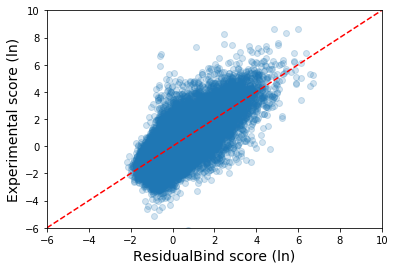

In [168]:
MIN=-6
MAX=10
plt.scatter(predictions, Y, alpha=0.2)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
plt.xlabel('ResidualBind score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


(-6, 10)

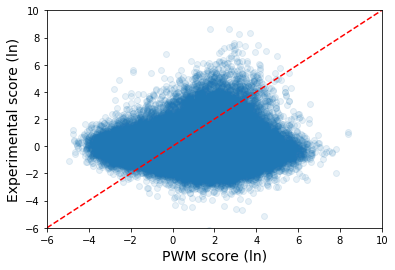

In [175]:
num_fit =70000
max_index = np.argsort(pwm_score)[::-1]
m, c = np.linalg.lstsq(np.vstack([pwm_score[max_index[:num_fit]], np.ones(num_fit)]).T, Y[max_index[:num_fit]])[0]

fig = plt.figure()
plt.scatter(pwm_score*9-14, Y, alpha=0.1)
plt.xlabel('PWM score (ln)', fontsize=14)
plt.ylabel('Experimental score (ln)', fontsize=14)
plt.plot([MIN, MAX], [MIN,MAX] ,'--r')
#plt.plot([-5,15],[-5,15],'--r')
plt.axis('tight');
plt.xlim([MIN,MAX])
plt.ylim([MIN,MAX])



In [176]:
print(spearmanr(pwm_score, Y))
print(np.corrcoef(pwm_score,Y))

SpearmanrResult(correlation=-0.0534589297143329, pvalue=6.520680890441293e-77)
[[ 1.         -0.02047468]
 [-0.02047468  1.        ]]


In [177]:
print(spearmanr(predictions[:,0], Y))
print(np.corrcoef(predictions[:,0],Y))

SpearmanrResult(correlation=0.6548762785237597, pvalue=0.0)
[[1.         0.72176024]
 [0.72176024 1.        ]]
